In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from scico import functional, linop, loss, metric
from scico.optimize import PDHG

import optuna

from src.forward_model.forward_operator import forward_operator
from src.forward_model.operators import *

from src.inversions.baseline_method.inversion_baseline import *

from src.input_initialization import initialize_input

/home/mullemat/.pyenv/versions/scico/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CFA = 'bayer'
BINNING = CFA == 'quad_bayer'
NOISE_LEVEL = 0

INPUT_DIR = 'input/'

In [3]:
x, spectral_stencil = initialize_input(INPUT_DIR + '01690.png')

cfa_op = cfa_operator(CFA, x.shape, spectral_stencil, 'dirac')
forward_op = forward_operator([cfa_op])
baseline_inverse = Inverse_problem(CFA, BINNING, 0, x.shape, spectral_stencil, 'dirac')

def forward_pass(x):
    return jnp.array(forward_op.direct(x))

def adjoint_pass(y):
    return jnp.array(forward_op.adjoint(y))

A = linop.LinearOperator(input_shape=x.shape, output_shape=x.shape[:-1], eval_fn=forward_pass, adj_fn=adjoint_pass)

C = linop.FiniteDifference(input_shape=x.shape, append=0, axes=(0, 1))
C_squared_norm = np.float64(linop.operator_norm(C))**2

y = np.clip(forward_op.direct(x) + np.random.normal(0, NOISE_LEVEL / 100, forward_op.output_shape), 0, 1)

f = loss.SquaredL2Loss(y=jnp.array(y), A=A)

x_baseline = jnp.array(baseline_inverse(y))

def objective(trial):
    lambd = trial.suggest_float('lambd', 1e-3, 0.2, log=True)
    sigma = trial.suggest_float('sigma', 1e-2, 100, log=True)
    tmp = trial.suggest_float('tmp', 1e-3, 1)
    tau = tmp / (sigma * C_squared_norm)

    g = lambd * functional.L21Norm(l2_axis=(0, 3))

    solver_TV = PDHG(
        f=f,
        g=g,
        C=C,
        tau=tau,
        sigma=sigma,
        x0=x_baseline,
        maxiter=1000
    )

    return metric.mse(x, solver_TV.solve())

study = optuna.create_study(direction='minimize', storage='sqlite:///main.sqlite3', study_name='tv', load_if_exists=True)
# study.optimize(objective, n_trials=40)
# best_trial = study.best_trial

[650 525 480]


[I 2023-09-06 14:29:17,125] Using an existing study with name 'tv' instead of creating a new one.


In [4]:
g = 0.00100 * functional.L21Norm(l2_axis=(0, 3))
sigma = 0.05085
tau = 0.42882 / (sigma * C_squared_norm)

tau, sigma = np.asarray(PDHG.estimate_parameters(C, x_baseline))
print(tau, sigma)

solver_TV = PDHG(
    f=f,
    g=g,
    C=C,
    tau=tau,
    sigma=sigma,
    x0=x_baseline,
    maxiter=1000
)

res = np.clip(np.array(solver_TV.solve()), 0, 1)

0.35620824 0.35620824


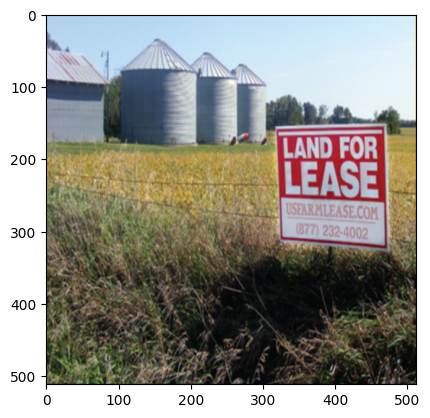

0.0011035014
0.00085827976


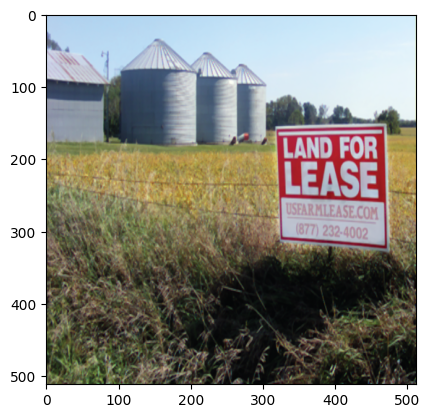

In [5]:
plt.imshow(x_baseline)
plt.show()
plt.imshow(res)

print(metric.mse(x, x_baseline), metric.psnr(x, x_baseline))
print(metric.mse(x, res), metric.psnr(x, res))